In [2]:
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from warnings import filterwarnings
# Pandas will give a lot of warning while I am mutating data frames in functions.
filterwarnings('ignore')
# Matplot lib inline
%matplotlib inline

### Choice of data and goal
- Data frames come from the same website so I can join on the column tconst with no lost observation other than
    differences dataframe length
- I want to create a dataframe that tags each observation with the genre that is in it's genre list
- Once I have merged, cleaned and added the genre boolean columns I will do rating by genre of recent years and 
    sufficently high vote count to convince me the findings are valid


In [3]:
df_title = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
df_ratings = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
print(f'df_title has a shape of {df_title.shape} and df_ratings has a shape of {df_ratings.shape}')

df_title has a shape of (146144, 6) and df_ratings has a shape of (73856, 3)


In [4]:
# merge the two data sets on tconst:
df_merge = df_title.merge(df_ratings, on='tconst', how='inner')
print(f'df_merge has a shape of {df_merge.shape}')

df_merge has a shape of (73856, 8)


In [5]:
df_merge.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517


#### From the head and info of the dataframe, we can see that the genres is in string form, we want it as a list

Once we have the string as a list of genres, we can create a superlist of all genres and take the set of that list. So let's do that next.

In [6]:
# remove all none values from the genre
def remove_null_genre(df):
    return df[df.genres.notnull()]
df = remove_null_genre(df_merge)

# coerce the genres to a list
df['genres'] = df.genres.apply(lambda x: x.split(','))

# generate a genre set of all genres present in the df
def genre_set_list(df):
    all_genres = list(df.genres)
    return list(set([item for sublist in all_genres for item in sublist]))

genre_List=(genre_set_list(df))
print(genre_List)

['Comedy', 'Action', 'Documentary', 'Sport', 'Musical', 'Adult', 'Animation', 'Romance', 'News', 'Game-Show', 'Fantasy', 'Horror', 'History', 'Biography', 'Drama', 'Music', 'Sci-Fi', 'Thriller', 'Adventure', 'Reality-TV', 'Short', 'Family', 'Crime', 'Western', 'Mystery', 'War']


Now I need a function that takes a dataframe and adds to it a boolean series for each genre in the genre_List

In [7]:
def create_boolean_series(series, genre):
        return [genre in genres for genres in series]
#function to append the series to a dataframe
def genre_list_to_series(df, L, genre):
    df[genre] = L 
    
def generate_genre_dataframe(df):
    # generate the list of genres
    L = genre_set_list(df)
    # Loops through the list of genres
    for genre in L:
        # Create a boolean series for each genre
        boolean_series = create_boolean_series(df.genres,genre)
        # Append that genre to the dataframe
        genre_list_to_series(df, boolean_series, genre)
    return df

#### Creating a dataframe template to append the genre columns onto

Now that we have all of our functions defined and working, we need to create a scaffold dataframe that we can append the genre columns to. For the purposes of our business question, we want to know what genre's are popular recently, so we will filter out all years before 2000 and because 2020 is 1) not over and 2) an anomoly we will not include it in our data frame.

In addition, we want movies that are truly popular for our analysis. Let's look at the median and mean number of votes most movies recieve

In [9]:
print(df.numvotes.mean(), df.numvotes.median())

3562.1726304550184 50.0


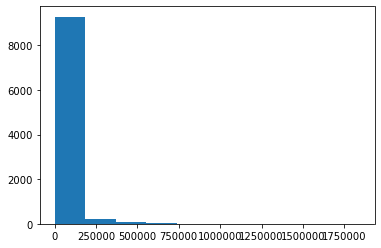

In [30]:
# Cleary the data is heavily influenced by less than 100,000 votes
plt.hist(df[df.numvotes>1000].numvotes, bins=10);

It seems like 10000 votes is a fair cut off for a movie to be considered popular.

In [28]:
# Create a data frame containing only data released since the year 2000 and before 2020 with atleast 1000 voties
df_scaffold = df[(df.start_year>2000)&(df.start_year<2020) & (df.numvotes > 1000)]

In [29]:
len(df_scaffold)

9609

In [32]:
# choice of column for the data frames
df_scaffold = df_scaffold[['tconst',
                           'primary_title', 
                           'genres', 
                           'numvotes', 
                           'averagerating',
                           'start_year', 
                           'runtime_minutes']]

In [34]:
df_genre = generate_genre_dataframe(df_scaffold)

In [36]:
df_genre.head()

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,Comedy,Action,Documentary,...,Drama,Music,Sci-Fi,Thriller,Adventure,Family,Crime,Western,Mystery,War
2,tt0069049,The Other Side of the Wind,[Drama],4517,6.9,2018,122.0,False,False,False,...,True,False,False,False,False,False,False,False,False,False
16,tt0249516,Foodfight!,"[Action, Animation, Comedy]",8248,1.9,2012,91.0,True,True,False,...,False,False,False,False,False,False,False,False,False,False
27,tt0293069,Dark Blood,[Thriller],1053,6.6,2012,86.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
31,tt0315642,Wazir,"[Action, Crime, Drama]",15378,7.1,2016,103.0,False,True,False,...,True,False,False,False,False,False,True,False,False,False
32,tt0323808,The Wicker Tree,"[Drama, Horror]",2328,3.9,2011,96.0,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [38]:
df_genre.shape

(9609, 30)

Perfect! We know have exactly what we want. To quickly test the data to check that it is usable lets create a dummy visualisation of average vote in each genre.

In [65]:
# Generate a plot based on the features of the genre list
def genre_dict_mean(df, feature, genre_list):
    genre_list = genre_set_list(df)
    feature_dict = {}
    for genre in genre_list:
        feature_dict.update({genre:df[df[f'{genre}'] == True][f'{feature}'].mean()})
        # Sort dictionary by value
    return {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1],reverse=True)}

def dict_to_pandas(dictionary):
    return pd.DataFrame.from_dict(dictionary, orient='index')

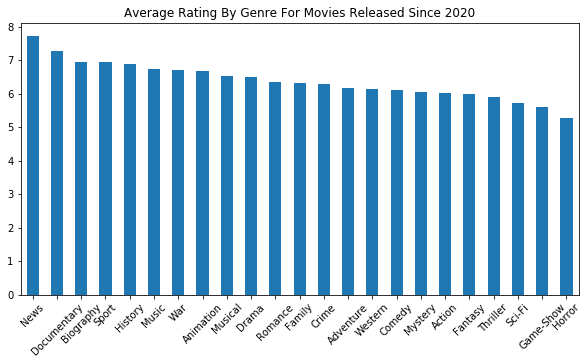

In [48]:
# Select the mean for the averagerating accross genres
foo = genre_dict_mean(df_genre, 'averagerating', genre_set_list(df_genre))
# Convert the dictionary into a data frame
df_foo = pd.DataFrame.from_dict(foo, orient='index')
df_foo.plot(kind='bar', figsize=(10,5), title='Average Rating By Genre For Movies Released Since 2020', legend=False)
plt.xticks(rotation=45);

In [66]:
df_genre.drop(columns='genres', inplace = True)
df_genre.to_csv('basics-ratings-genre.csv', index=False)

KeyError: "['genres'] not found in axis"

In [63]:
df = pd.read_csv('basics-ratings-genre.csv')

In [64]:
df

,tconst,primary_title,numvotes,averagerating,start_year,runtime_minutes,Comedy,Action,Documentary,Sport,...,Drama,Music,Sci-Fi,Thriller,Adventure,Family,Crime,Western,Mystery,War
0,tt0069049,The Other Side of the Wind,4517,6.9,2018,122.0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,tt0249516,Foodfight!,8248,1.9,2012,91.0,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,tt0293069,Dark Blood,1053,6.6,2012,86.0,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,tt0315642,Wazir,15378,7.1,2016,103.0,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
4,tt0323808,The Wicker Tree,2328,3.9,2011,96.0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9604,tt9558612,PM Narendra Modi,4057,3.7,2019,136.0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
9605,tt9562694,Alien Warfare,1509,2.6,2019,88.0,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
9606,tt9573980,Leaving Neverland,19632,7.1,2019,240.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9607,tt9778170,Panodrama,2220,3.1,2019,64.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
